In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import zip_longest
from sklearn.utils import shuffle
import random
np.set_printoptions(suppress=True)

In [2]:
SEED = 8
random.seed(SEED)
def shuffle_forward(l):
    order = list(range(len(l)))
    random.shuffle(order)
    return np.array(np.array(l)[order]), order

def shuffle_backward(l, order):
    l_out = [0] * len(l)
    for i, j in enumerate(order):
        l_out[j] = l[i]
    return l_out

In [10]:
class SingleLayerSNN:
    
    def __init__(self, inputs, weights, trainings, Cm=4, Rm=5, V_thresh=30, V_rest=-65, V_spike=80, dT=0.01, rate=1):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        inputs (double[][][]): A 3d numpy array of the input voltages per timestep
                        weights (double[]): A numpy array of initial weights
                        outputs (double[][][]): A 3d numpy array of the output voltages per timestep used for teaching neuron
                Returns:
                        None
        """
        
        assert len(trainings) == len(inputs)
            
        self.inputs = inputs
        self.weights = weights
        self.trainings = trainings
        self.Cm = Cm
        self.Rm = Rm
        self.V_thresh = V_thresh
        self.V_rest = V_rest
        self.V_spike = V_spike
        self.dT = dT # ms
        self.rate = rate # sec
        self._LIF_spikes = 0                    
        
    def LIF(self, I):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        total_time = (I.size) * self.dT

        # an array of time
        time = np.arange(0, total_time, self.dT)

        # default voltage list set to resting volatage of -65mV
        V = (self.V_rest) * np.ones(len(time))

        did_spike = False

        # function member variable to track spikes
        self._LIF_spikes = 0

        for t in range(len(time)):
            # using "I - V(t)/Rm = Cm * dV/dT"
            dV = (I[t] - (V[t - 1] - self.V_rest) / self.Rm) / self.Cm

            # reset membrane potential if neuron spiked last tick
            if did_spike:
                V[t] = self.V_rest + dV * self.dT
            else:
                V[t] = V[t - 1] + dV * self.dT

            # check if membrane voltage exceeded threshold (spike)
            if V[t] > self.V_thresh:
                did_spike = True
                # set the last step to spike value
                V[t] = self.V_spike
                self._LIF_spikes += 1
            else:
                did_spike = False

        return V
    
    def voltage_to_output(self, V_input):
        V_output = np.array([])
        for v in V_input:
            V_output = np.append(V_output, 0 if v < self.V_spike else self.V_spike)
        return V_output
    
    def voltage_to_spike_rate(self, voltages, dT=None, rate=None):
        if not dT:
            dT = self.dT
        if not rate:
            rate = self.rate
            
#         print('voltages', voltages)
        
        def cond(V):
            return V >= self.V_spike
        
        spike_count = sum(cond(V) for V in voltages)
        
#         print('spike_count', spike_count)
        
        total_time_dT = len(voltages) * dT
#         print(f'total_time_dT: {total_time_dT} ({dT}ms)')
        
        spikes_per_dT = spike_count / total_time_dT
#         print(f'spikes_per_ms: {spikes_per_dT} (spikes/ms)')
        
        return spikes_per_dT * 1000 * rate     
    
    # returns the voltages of input and output neurons
    def feed_forward(self, inputs, train=True):
        all_input_voltages = []
        all_output_voltages = []
        
        # set the training voltages to all zero if not running in training mode
        training_copy = np.zeros(inputs.shape, np.ndarray) if not train else np.array(self.trainings)
#         print('training_copy:')
#         print(training_copy)
        
        inputs_copy = np.array(inputs)
#         print('inputs_copy:')
#         print(inputs_copy)

        
        assert len(training_copy) == len(inputs_copy)
        
        zipped = list(zip(inputs_copy, training_copy))
        
        shuffled, order = shuffle_forward(zipped)
        shuffled_inputs, shuffled_trainings = zip(*shuffled)
        
        shuffled_inputs = np.array(shuffled_inputs)
#         print('shuffled_inputs:')
#         print(shuffled_inputs)

        
        
        for input_set, training_set in zip_longest(shuffled_inputs, shuffled_trainings):
            input_voltages = []
            for V_input in input_set:
                input_voltages.append(self.LIF(V_input))
                
            output_inputs = []
            input_outputs = [] # DEBUG ONLY
            for weight_set in self.weights.T:
                weighted_sum = np.zeros(len(input_set[0]))
                for V_input, weight in zip(input_voltages, weight_set):
                    # filter for spikes b/c a neuron only outputs if it spikes
                    input_output = self.voltage_to_output(V_input)
                    input_outputs.append(input_output) # DEBUG ONLY
                    weighted = input_output * weight
                    weighted_sum = np.add(weighted_sum, weighted)
            
                output_inputs.append(weighted_sum)
            
            input_voltages = np.array(input_voltages)
            input_outputs = np.array(input_outputs)
            output_inputs = np.array(output_inputs)
            
#             print('input_voltages:')
#             print(input_voltages)
#             print('input_outputs:')
#             print(input_outputs)
#             print('output_inputs:')
#             print(output_inputs)
#             print('training_set:')
#             print(training_set)
            
            all_input_voltages.append(input_voltages)
            
            # inject training voltage if in training mode
            assert isinstance(training_set, (list, np.ndarray))
            for i, (output_input, training_input) in enumerate(zip(output_inputs, training_set)):
                assert isinstance(training_input, (list, np.ndarray))
#               padded_training_input = np.pad(training_input, (0, len(output_inputs) - len(training_set)), "constant")
                output_inputs[i] = output_input + training_input
                
#             print('output_inputs after injecting training current')
#             print(output_inputs)
        
            # run LIF on output neurons
            output_voltages = []
            for V_input in output_inputs:
                output_voltages.append(self.LIF(V_input))
                            
            output_voltages = np.array(output_voltages)
            all_output_voltages.append(output_voltages)
            
#             print('output_voltages:')
#             print(output_voltages)
        
        # unshuffle the voltages
        all_input_voltages = np.array(shuffle_backward(all_input_voltages, order))
        all_output_voltages = np.array(shuffle_backward(all_output_voltages, order))
        
        return all_input_voltages, all_output_voltages
                
                    
    def train(self, epochs=100, a_corr=0.0005, w_max=500, w_decay=0):
        
        weights_history = []
        for weight_set in self.weights:
            weight_row = []
            for weight in weight_set:
                weight_row.append([weight])
            weights_history.append(weight_row)
        
        for epoch in range(epochs):
            print(f'Epoch: {epoch + 1}')
            
            all_input_voltages, all_output_voltages = self.feed_forward(self.inputs, train=True)
            
            # debug info
#             print()
#             print('------------------------------------------------')
#             print('all_input_voltages:')
#             print(all_input_voltages)
#             print('all_output_voltages:')
#             print(all_output_voltages)
            
#             print('weights:')
#             print(self.weights)
                        
            # apply learning rule
            for input_voltages, output_voltages in zip(all_input_voltages, all_output_voltages):
#                 print('input_voltages', input_voltages)
                for i, (input_voltage_set, weight_set) in enumerate(zip(input_voltages, self.weights)):
#                     print('input_voltage_set', input_voltage_set)
                    input_rate = self.voltage_to_spike_rate(input_voltage_set)
#                     print(f'input_rate {i}:', input_rate)
        
                    for j, (output_voltage_set, weight) in enumerate(zip(output_voltages, weight_set)):
                        output_rate = self.voltage_to_spike_rate(output_voltage_set)
#                         print(f'\toutput_rate {j}:', output_rate)
                        
                        # adjust the weight using Hebb with decay
                        weight_change = a_corr * input_rate * output_rate - w_decay
#                         print('\told weight', weight)
#                         print('\tweight_change:', weight_change)
                        
                        if weight + weight_change < 0:
                            self.weights[i][j] = 0
                        elif weight + weight_change > w_max:
                            self.weights[i][j] = w_max
                        else:
                            self.weights[i][j] = weight + weight_change                        
                            
#                         print('\tnew weight', self.weights[i][j], '\n')

            # update weight history
            for i, weight_set in enumerate(self.weights):
                for j, weight in enumerate(weight_set):
                    weights_history[i][j].append(weight)
                        
            print(self.weights)
            
            # plot data
#             for i, (input_voltages, output_voltages) in enumerate(zip(all_input_voltages, all_output_voltages)):
#                 plt.figure(figsize=(20,10))
#                 plt.suptitle(f'Input: {i + 1}', fontsize=18)
#                 for input_voltage in input_voltages:
#                     plt.plot(input_voltage, 'b:', alpha=.5)
                    
#                 for output_voltage in output_voltages:
#                     plt.plot(output_voltage, 'r--', alpha=.5)
                
#             plt.show()
        
        # plot weights history
        plt.figure(figsize=(20,10))
        for i, weight_row in enumerate(weights_history):
            for j, weight_history in enumerate(weight_row):
                plt.plot(weight_history, label=f'weight {i}-{j}')
        plt.legend(loc="upper left")
        plt.show()
        
    def predict(self, inputs):
        all_input_voltages, all_output_voltages = self.feed_forward(inputs, train=False)
        print('all_output_voltages')
        print(all_output_voltages)
        for x, (input_voltages, output_voltages) in enumerate(zip(all_input_voltages, all_output_voltages)):
            print('input set:', x)
            for i, input_voltage_set in enumerate(input_voltages):
                print(f'\tinput {i}: {self.voltage_to_spike_rate(input_voltage_set)} spikes/{self.rate}s')
            print()
            for i, output_voltage_set in enumerate(output_voltages):
                print(f'\toutput {i}: {self.voltage_to_spike_rate(output_voltage_set)} spikes/{self.rate}s')
            print()


Epoch: 1
[[0.795525 0.170175]
 [0.       0.72035 ]
 [0.795525 0.265175]
 [0.       0.62535 ]]
Epoch: 2
[[1.59105  0.170175]
 [0.       1.0607  ]
 [1.59105  0.265175]
 [0.       0.9657  ]]
Epoch: 3
[[2.386575 0.170175]
 [0.       1.40105 ]
 [2.386575 0.265175]
 [0.       1.30605 ]]
Epoch: 4
[[3.1821   0.170175]
 [0.       1.7414  ]
 [3.1821   0.265175]
 [0.       1.6464  ]]
Epoch: 5
[[3.977625 0.170175]
 [0.       2.08175 ]
 [3.977625 0.265175]
 [0.       1.98675 ]]
Epoch: 6
[[4.77315  0.170175]
 [0.       2.4221  ]
 [4.77315  0.265175]
 [0.       2.3271  ]]
Epoch: 7
[[5.568675 0.170175]
 [0.       2.76245 ]
 [5.568675 0.265175]
 [0.       2.66745 ]]
Epoch: 8
[[6.3642   0.170175]
 [0.       3.1028  ]
 [6.3642   0.265175]
 [0.       3.0078  ]]
Epoch: 9
[[7.159725 0.170175]
 [0.       3.44315 ]
 [7.159725 0.265175]
 [0.       3.34815 ]]
Epoch: 10
[[7.95525  0.170175]
 [0.       3.7835  ]
 [7.95525  0.265175]
 [0.       3.6885  ]]
Epoch: 11
[[8.750775 0.170175]
 [0.       4.12385 ]
 [8.750

[[29.715     0.170175]
 [ 0.       28.2887  ]
 [29.715     0.265175]
 [ 0.       28.1937  ]]
Epoch: 83
[[29.715     0.170175]
 [ 0.       28.62905 ]
 [29.715     0.265175]
 [ 0.       28.53405 ]]
Epoch: 84
[[29.715     0.170175]
 [ 0.       28.9694  ]
 [29.715     0.265175]
 [ 0.       28.8744  ]]
Epoch: 85
[[29.715     0.170175]
 [ 0.       29.30975 ]
 [29.715     0.265175]
 [ 0.       29.21475 ]]
Epoch: 86
[[29.715     0.170175]
 [ 0.       29.6501  ]
 [29.715     0.265175]
 [ 0.       29.5551  ]]
Epoch: 87
[[29.715     0.170175]
 [ 0.       29.99045 ]
 [29.715     0.265175]
 [ 0.       29.89545 ]]
Epoch: 88
[[29.715     0.170175]
 [ 0.       30.      ]
 [29.715     0.265175]
 [ 0.       30.      ]]
Epoch: 89
[[29.715     0.170175]
 [ 0.       30.      ]
 [29.715     0.265175]
 [ 0.       30.      ]]
Epoch: 90
[[29.715     0.170175]
 [ 0.       30.      ]
 [29.715     0.265175]
 [ 0.       30.      ]]
Epoch: 91
[[29.715     0.170175]
 [ 0.       30.      ]
 [29.715     0.265175]
 [ 0

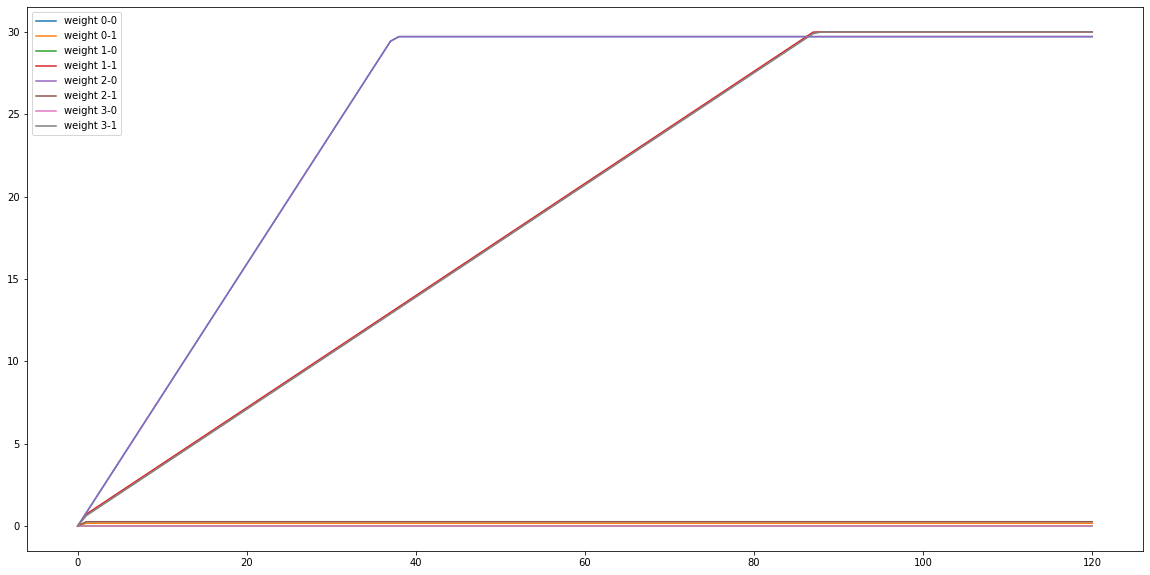

all_output_voltages
[[[-65.         -65.         -65.         ...   2.59014687   2.5563518
     2.52257362]
  [-65.         -65.         -65.         ... -62.17208605 -62.17350001
   -62.17491326]]

 [[-65.         -65.         -65.         ...   3.54410936   3.5098373
     3.47558238]
  [-65.         -65.         -65.         ...   4.59492786   4.5601304
     4.52535033]]

 [[-65.         -65.         -65.         ...   3.54410936   3.5098373
     3.47558238]
  [-65.         -65.         -65.         ...   4.81424518   4.77933805
     4.74444838]]

 [[-65.         -65.         -65.         ... -65.         -65.
   -65.        ]
  [-65.         -65.         -65.         ...   3.23902787   3.20490836
     3.1708059 ]]]
input set: 0
	input 0: 2550.0 spikes/1s
	input 1: 0.0 spikes/1s
	input 2: 2550.0 spikes/1s
	input 3: 0.0 spikes/1s

	output 0: 250.0 spikes/1s
	output 1: 0.0 spikes/1s

input set: 1
	input 0: 2550.0 spikes/1s
	input 1: 0.0 spikes/1s
	input 2: 0.0 spikes/1s
	input 3: 2550.

In [13]:
u_t = 2000 # units of time
i_a = 1000.0 # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array([
    [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t], # x: T, y: T --> T
    [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t], # x: T, y: T --> T
    [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t], # x: T, y: T --> T
    [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t], # x: T, y: F --> F
    [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t], # x: F, y: T --> F
    [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t], # x: F, y: F --> F
])

t_a = 1000.0 # training amount
s_a = -100.0 # supress amount

# current that gets injected to the output neurons
trainings = np.array([
    [[t_a] * u_t, [s_a] * u_t], # T
    [[t_a] * u_t, [s_a] * u_t], # T
    [[t_a] * u_t, [s_a] * u_t], # T
    [[s_a] * u_t, [t_a] * u_t], # F
    [[s_a] * u_t, [t_a] * u_t], # F
    [[s_a] * u_t, [t_a] * u_t], # F
])

# initiate the weights to be half of max weight
weights = np.array([
    [0.0, 0.0], 
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
])

and_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

and_network.train(epochs=120, a_corr=0.00000007, w_max=30.0, w_decay=0.095)

# the four possible cases
predict_inputs = np.array([
    [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t], # x: T, y: T --> T
    [[i_a] * u_t, [0.0] * u_t, [0] * u_t, [i_a] * u_t], # x: T, y: F --> F
    [[0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t], # x: F, y: T --> F
    [[0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t], # x: F, y: F --> F
])
and_network.predict(predict_inputs)

# and_network.voltage_to_spike_rate([80, 80, 80, 80, 80, 0, 0, 0, 0, 0, 80, 80], dT=0.01, rate=1)


In [5]:
a = np.array([1, 2, 3, 4])
b = np.array([1, 2])
b = np.pad(b, (0, len(a) - len(b)), "constant")
c = [2, 3, 5]

shuffled, order = shuffle_forward(a)
print('shuffled:', shuffled)
unshuffled = shuffle_backward(shuffled, order)
print('unshuffled:', unshuffled)


shuffled: [4 1 3 2]
unshuffled: [1, 2, 3, 4]
